In [3]:
import pandas as pd
import re
from sklearn.model_selection import ShuffleSplit
import numpy as np

merged_data = pd.read_csv("/Users/jiayingyou/Downloads/ar_mutants/merged_dataset.csv",index_col=False)
drug_data =  pd.read_csv("/Users/jiayingyou/Downloads/ar_mutants/morgan_fp_drug_128.csv")
protein_data =  pd.read_csv("/Users/jiayingyou/Downloads/ar_mutants/protein_desc_mutant.csv")
merged_data = merged_data.merge(drug_data, left_on=['drug'], right_on=['drug'])
merged_data = merged_data.merge(protein_data, left_on=['mutant'], right_on=['mutant'])
df = merged_data.iloc[:,1:]


===== Fold 1 =====

===== Fold 2 =====

===== Fold 3 =====

===== Fold 4 =====

===== Fold 5 =====

Mean Cross-Validation Accuracy - Random Forest: 0.6830
Mean Cross-Validation Accuracy - SVM: 0.7245


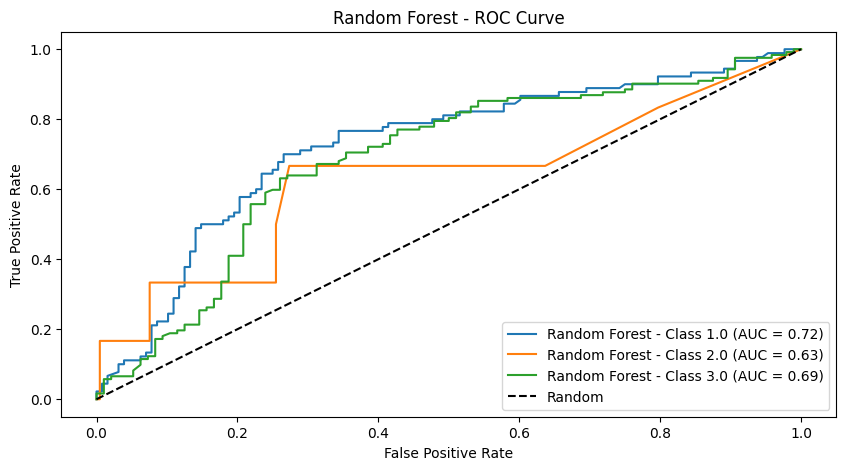

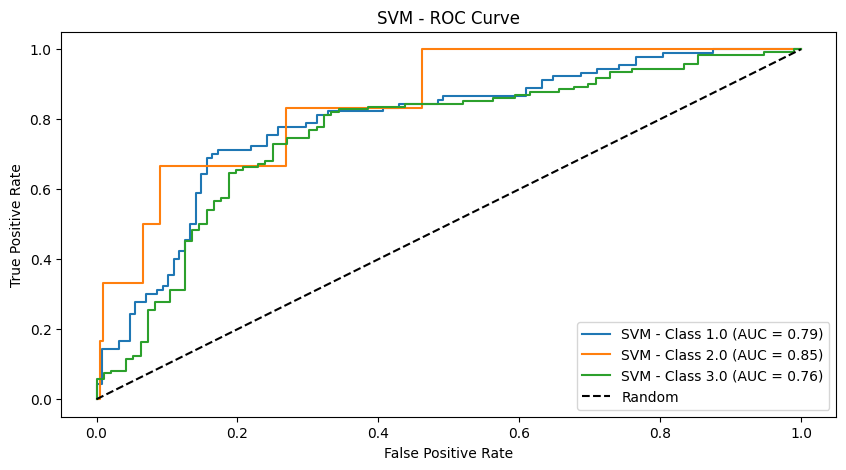

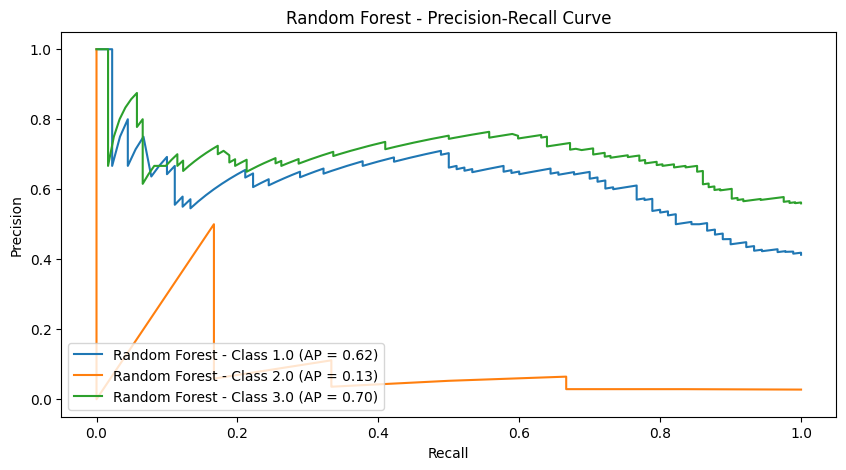

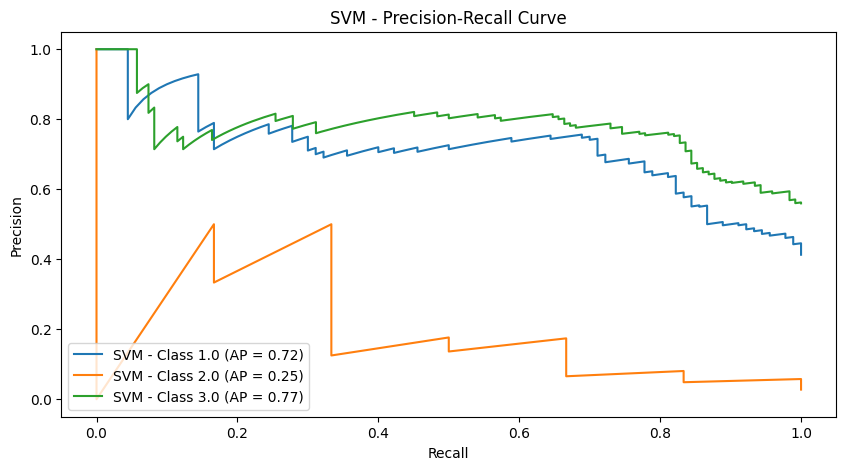

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score
from imblearn.over_sampling import SMOTE

# --- Load Your Data (Assuming 'df' is already loaded) ---
# X: Features (Morgan fingerprints start from the 4th column)
X = df.iloc[:, 3:].values  
y = df['trend'].values  
groups = df['mutant'].values  # Ensure no mutant appears in both train and test

# --- Standardization & Dimensionality Reduction ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=64)  # Reduce to 64 dimensions
X_pca = pca.fit_transform(X_scaled)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Define GroupKFold cross-validation ---
gkf = GroupKFold(n_splits=5)

# Store cross-validation results
cv_results_rf = []
cv_results_svm = []
all_true_labels_rf = []
all_pred_probs_rf = []
all_true_labels_svm = []
all_pred_probs_svm = []

# --- 5-Fold Cross-Validation ---
for fold, (train_idx, test_idx) in enumerate(gkf.split(X_pca, y_encoded, groups=groups)):
    print(f"\n===== Fold {fold + 1} =====")
    
    # Split data
    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
    
    # Apply SMOTE on Training Data Only
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=3)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Train and Evaluate Random Forest Model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_resampled, y_train_resampled)
    rf_pred_probs = rf_model.predict_proba(X_test)
    rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
    cv_results_rf.append(rf_accuracy)
    all_true_labels_rf.extend(y_test)
    all_pred_probs_rf.extend(rf_pred_probs)

    # Train and Evaluate SVM Model
    svm_model = SVC(kernel='rbf', probability=True, random_state=42)
    svm_model.fit(X_train_resampled, y_train_resampled)
    svm_pred_probs = svm_model.predict_proba(X_test)
    svm_accuracy = accuracy_score(y_test, svm_model.predict(X_test))
    cv_results_svm.append(svm_accuracy)
    all_true_labels_svm.extend(y_test)
    all_pred_probs_svm.extend(svm_pred_probs)

# Compute Mean CV Accuracy for Both Models
mean_accuracy_rf = np.mean(cv_results_rf)
mean_accuracy_svm = np.mean(cv_results_svm)
print(f"\nMean Cross-Validation Accuracy - Random Forest: {mean_accuracy_rf:.4f}")
print(f"Mean Cross-Validation Accuracy - SVM: {mean_accuracy_svm:.4f}")

# --- ROC and Precision-Recall plots ---
def plot_roc_curve(true_labels, pred_probs, model_name):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(true_labels, pred_probs[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 5))
    for i in range(len(le.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'{model_name} - Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(true_labels, pred_probs, model_name):
    precision, recall, average_precision = {}, {}, {}

    # Ensure true_labels and pred_probs are arrays
    true_labels = np.array(true_labels)
    pred_probs = np.array(pred_probs)

    for i in range(len(le.classes_)):
        precision[i], recall[i], _ = precision_recall_curve(true_labels == i, pred_probs[:, i])
        average_precision[i] = average_precision_score(true_labels == i, pred_probs[:, i])

    plt.figure(figsize=(10, 5))
    for i in range(len(le.classes_)):
        plt.plot(recall[i], precision[i], label=f'{model_name} - Class {le.classes_[i]} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Plot ROC and Precision-Recall for both models
plot_roc_curve(all_true_labels_rf, np.array(all_pred_probs_rf), 'Random Forest')
plot_roc_curve(all_true_labels_svm, np.array(all_pred_probs_svm), 'SVM')

plot_precision_recall_curve(all_true_labels_rf, np.array(all_pred_probs_rf), 'Random Forest')
plot_precision_recall_curve(all_true_labels_svm, np.array(all_pred_probs_svm), 'SVM')
